# Software Pricing
## EDA and Feature Engineering
**Paul Sims**

# Setup

## Imports

In [137]:
# Plotting 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("poster")
sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("whitegrid")
sns.set(font_scale = 1.5)

# Data manipulation
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

from pandas_profiling import ProfileReport

# Utility
import rootpath as rp

# ML and stats
from sklearn.model_selection import train_test_split


## Read in data

In [138]:
# Set paths

# Root
rpath = rp.detect() + '/'

# Data directory
data_direct = 'data/'

In [139]:
# Read in data

df_clean = pd.read_csv(rpath+data_direct+'clean/'+'data_clean.csv',
                          sep=",", index_col=0)

In [140]:
# Convert timestamp to date time

df_clean['timestamp'] = pd.to_datetime(df_clean['timestamp'],
                                        errors='coerce')

In [141]:
df_clean.head()

,user_id,timestamp,source,device,os,test,price,converted,source_type,date,time,city,country,lat,long
0,604839,2015-05-08 03:38:34,facebook,mobile,apple,0,39.0,0,ads,2015-05-08,03:38:34,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,google,mobile,android,0,39.0,0,seo,2015-05-10,21:08:46,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,bing,mobile,android,0,39.0,0,ads,2015-04-04,15:01:23,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,apple,1,59.0,0,direct_traffic,2015-05-07,07:26:01,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,facebook,web,apple,0,39.0,0,ads,2015-05-24,11:04:40,Fishers,USA,39.95,-86.02


In [142]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 275616 entries, 0 to 275615
Data columns (total 15 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   user_id      275616 non-null  int64         
 1   timestamp    275322 non-null  datetime64[ns]
 2   source       275344 non-null  object        
 3   device       275616 non-null  object        
 4   os           257839 non-null  object        
 5   test         275616 non-null  int64         
 6   price        275616 non-null  float64       
 7   converted    275616 non-null  int64         
 8   source_type  275616 non-null  object        
 9   date         275322 non-null  object        
 10  time         275322 non-null  object        
 11  city         275616 non-null  object        
 12  country      275616 non-null  object        
 13  lat          275616 non-null  float64       
 14  long         275616 non-null  float64       
dtypes: datetime64[ns](1), float64(3), 

# EDA

## Check for imbalance in target variable

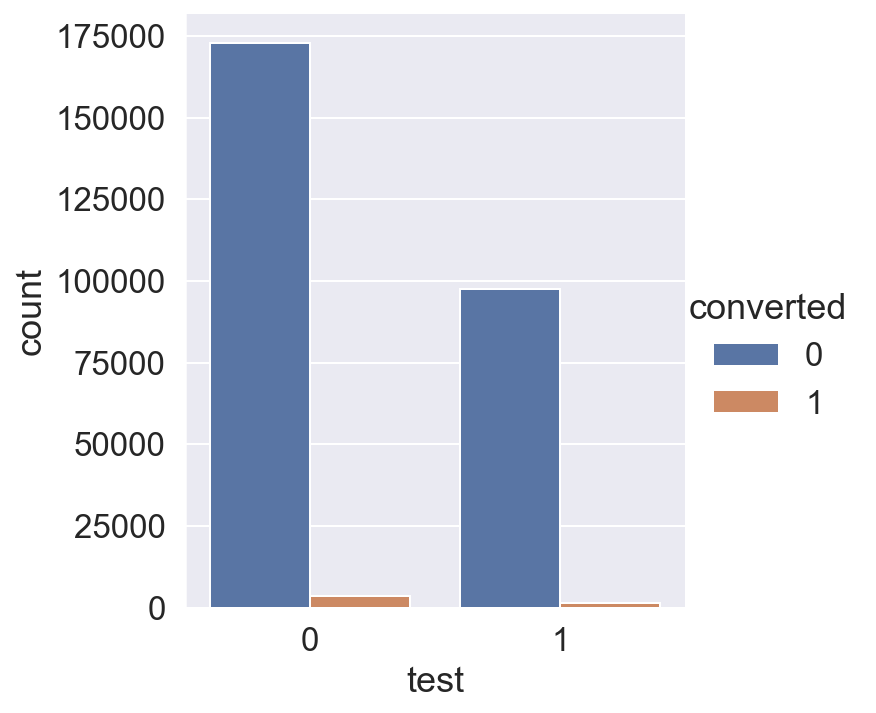

In [143]:
# Plot conversions vs. non-conversions for both test groups

sns.catplot(x="test",
            hue="converted",
            data=df_clean, kind="count")

- Highly imbalanced so may need to consider that in a model
- Very low numbers of conversion in general
- Better to plot conversion rate on the same scale for comparison

**Calculate the exact numbers of conversions in each test group**

In [144]:
# Count instances of converted/non-converted in each test group  

test_cts = (
    df_clean.groupby('test')['converted'] \
               .value_counts(normalize=False).to_frame()
)

In [145]:
# Rename col and flatten df

test_cts = (
    test_cts.rename(columns={"converted": "counts"}).reset_index()
)

In [146]:
test_cts

,test,converted,counts
0,0,0,172939
1,0,1,3489
2,1,0,97658
3,1,1,1530


**Calculate the proportion of conversion for each test**

In [147]:
# Calculate conversion rate in each test group

test_prop = (
    df_clean.groupby('test')['converted'] \
               .value_counts(normalize=True).to_frame()
)

In [148]:
# Reset index and rename converted column

test_prop = (
    test_prop.rename(columns={"converted": "convert_rate"}).reset_index()
)

In [149]:
test_prop

,test,converted,convert_rate
0,0,0,0.980224
1,0,1,0.019776
2,1,0,0.984575
3,1,1,0.015425


<AxesSubplot:xlabel='test', ylabel='convert_rate'>

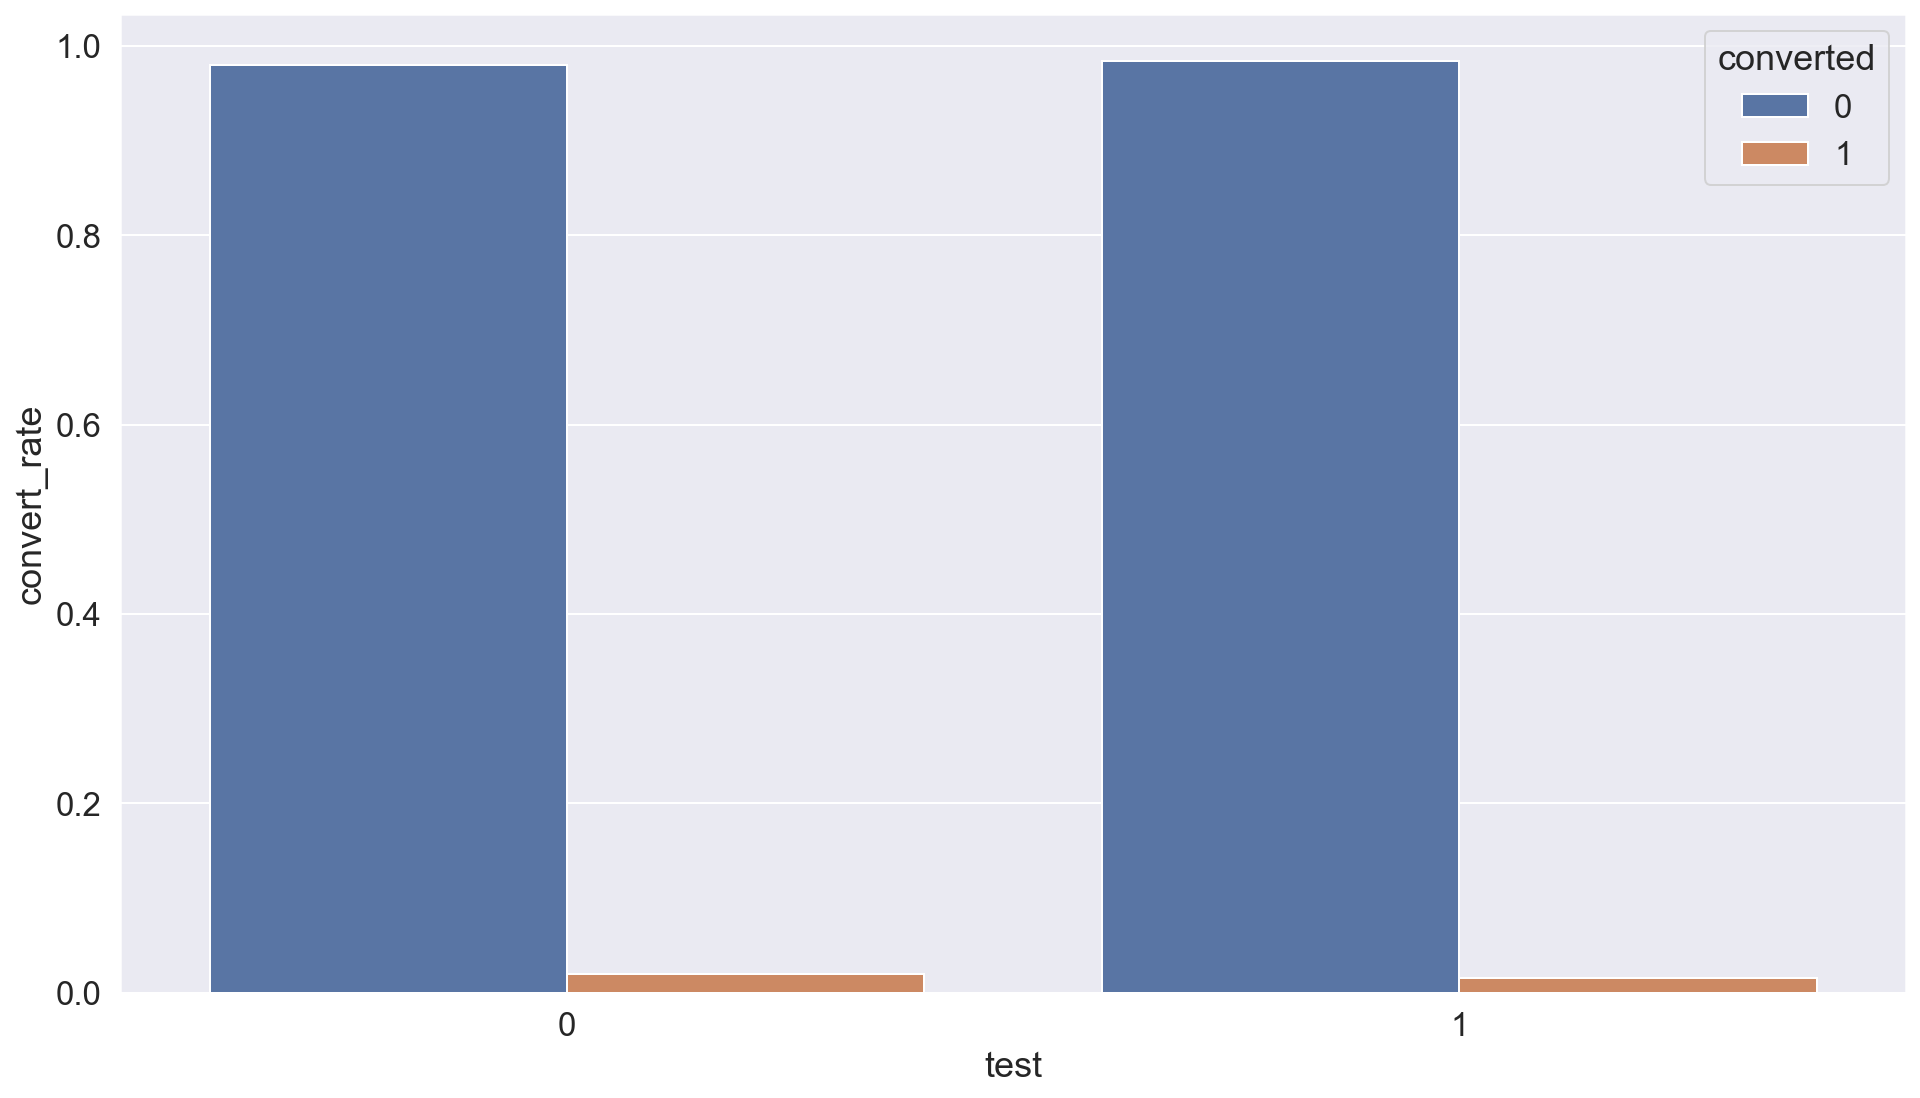

In [150]:
# Plot of proportions

sns.barplot(x="test",
            y="convert_rate",
            hue="converted",
            data=test_prop)

## Split data into train and test sets

**Create feature and target variables**

In [151]:
# Remove NA values

df_clean = df_clean.dropna()

In [152]:
# Feature df 

X = df_clean.drop(['converted'], axis=1)

In [153]:
# Target df

y = df_clean['converted']

In [154]:
# Train test split with 80% data in training set
# Stratify due to class imbalance in conversion rate
# EDA feature sets since I will remove some features later on likely

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    test_size=0.3,
                                                    random_state=42)

In [155]:
# Rejoin features and target

df_eda = X_train.assign(converted=y_train)
df_test = X_test.assign(converted=y_test)

In [156]:
# Export training data

df_eda.to_csv(rpath+data_direct+'clean/'+'data_train.csv')
df_test.to_csv(rpath+data_direct+'clean/'+'data_test.csv')

In [157]:
# Get EDA from pandas profiling

profile = ProfileReport(df_eda, title="Pandas Profiling Report",
                        explorative=True)

In [158]:
# View pandas profiling via widgets

#profile.to_widgets()

### Conversions over time of day

In [159]:
# Filter only conversions
# Remove conversion data without dates

df_convert = df_eda.query("converted == 1 & date.notnull()",
                            engine='python').copy()

In [160]:
# Create hourly variable

df_convert['hour'] = df_convert.timestamp.dt.hour

In [161]:
# Calculate totals by hour

df_sum_daily_t = df_convert.groupby(['test','hour'],
                                dropna=False) \
                            ['price'].count().reset_index()

df_sum_daily_t.rename(columns={"price":"counts"}, inplace=True)

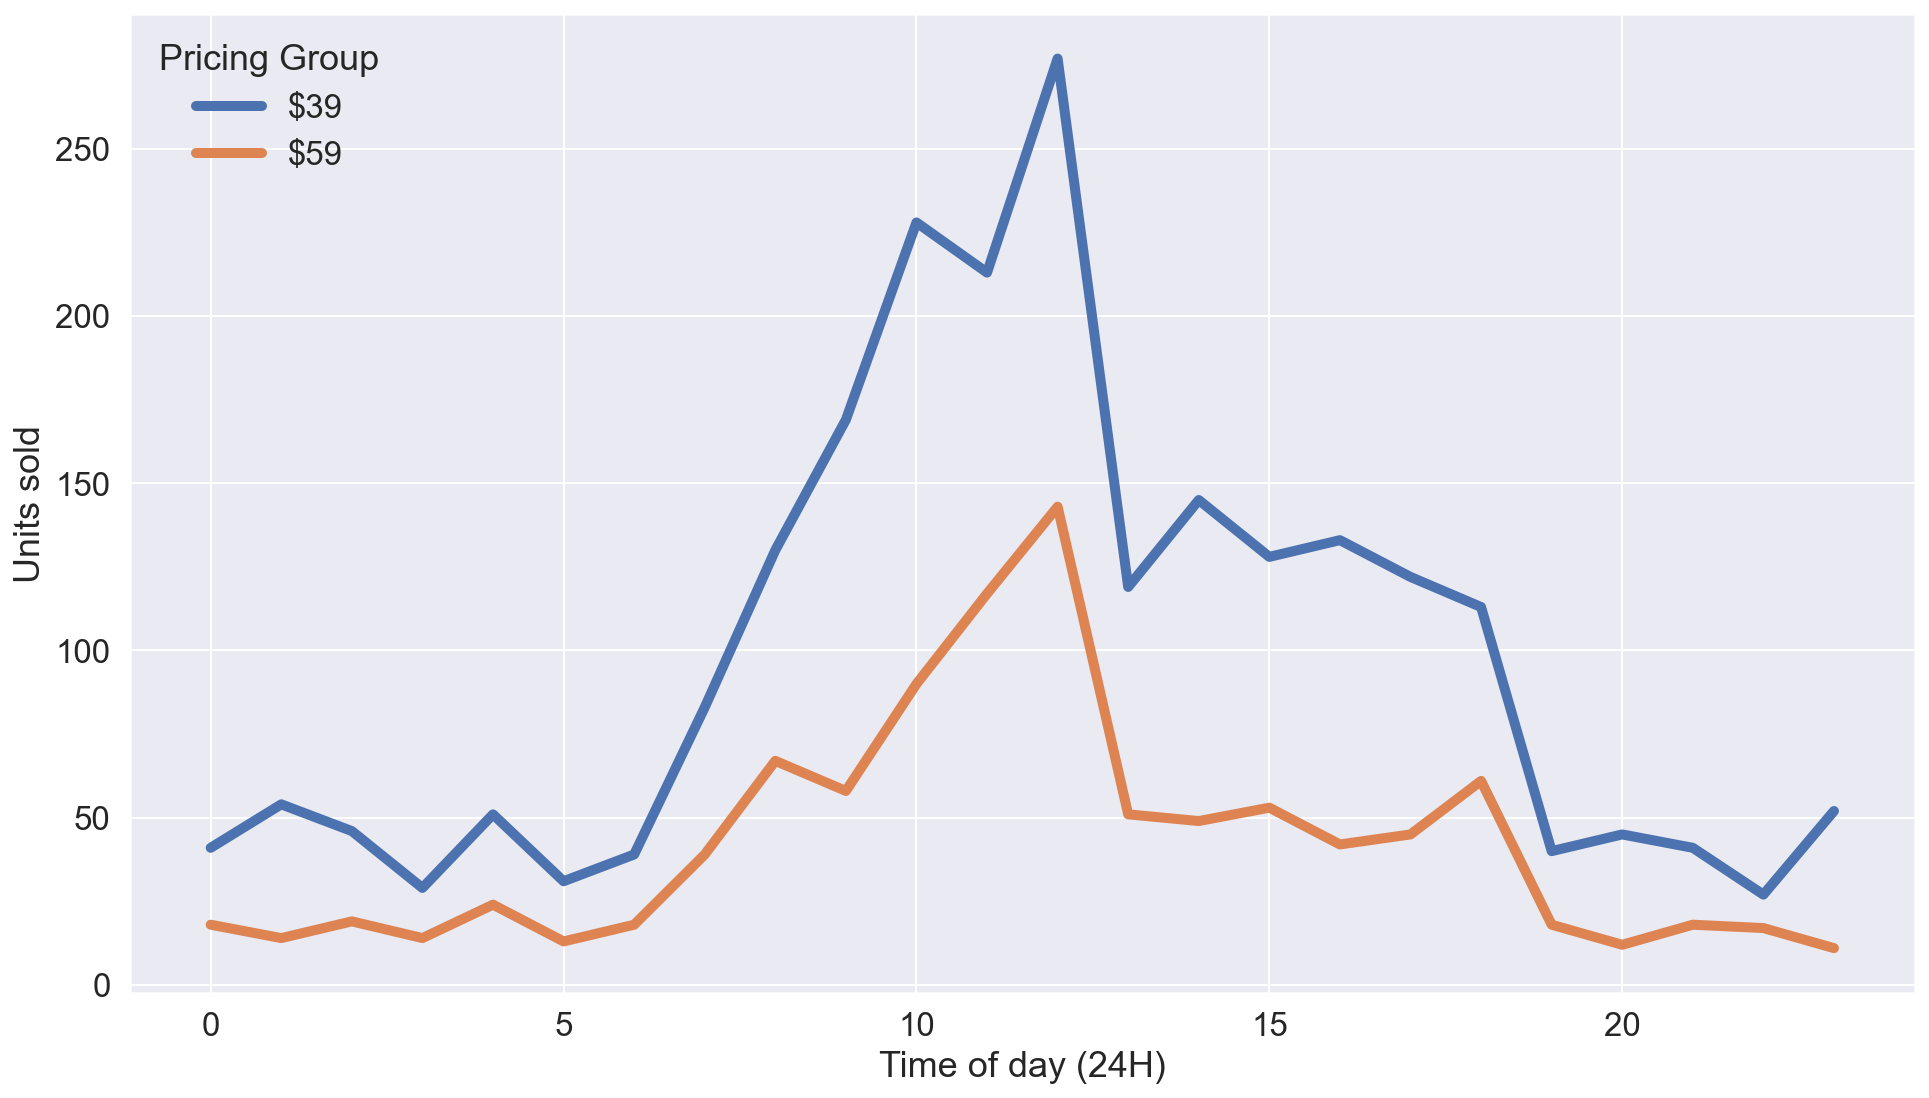

In [162]:
# Plot relationship of units sold over time of day for each group

p = sns.lineplot(data=df_sum_daily_t, x="hour", y="counts",
                 hue='test', linewidth=5)
plt.xlabel('Time of day (24H)')
plt.ylabel('Units sold')
plt.legend(loc='upper left', frameon=False, title='Pricing Group',
           labels=['$39', '$59'])

- Time of day is clearly important, there's a spike around 12 pm

### Conversions by minute of hour

In [163]:
# Create minute variable

df_convert['min'] = df_convert.timestamp.dt.minute

In [164]:
# Calculate totals by hour

df_sum_daily_t = df_convert.groupby(['test','min'],
                                dropna=False) \
                            ['price'].count().reset_index()

df_sum_daily_t.rename(columns={"price":"counts"}, inplace=True)

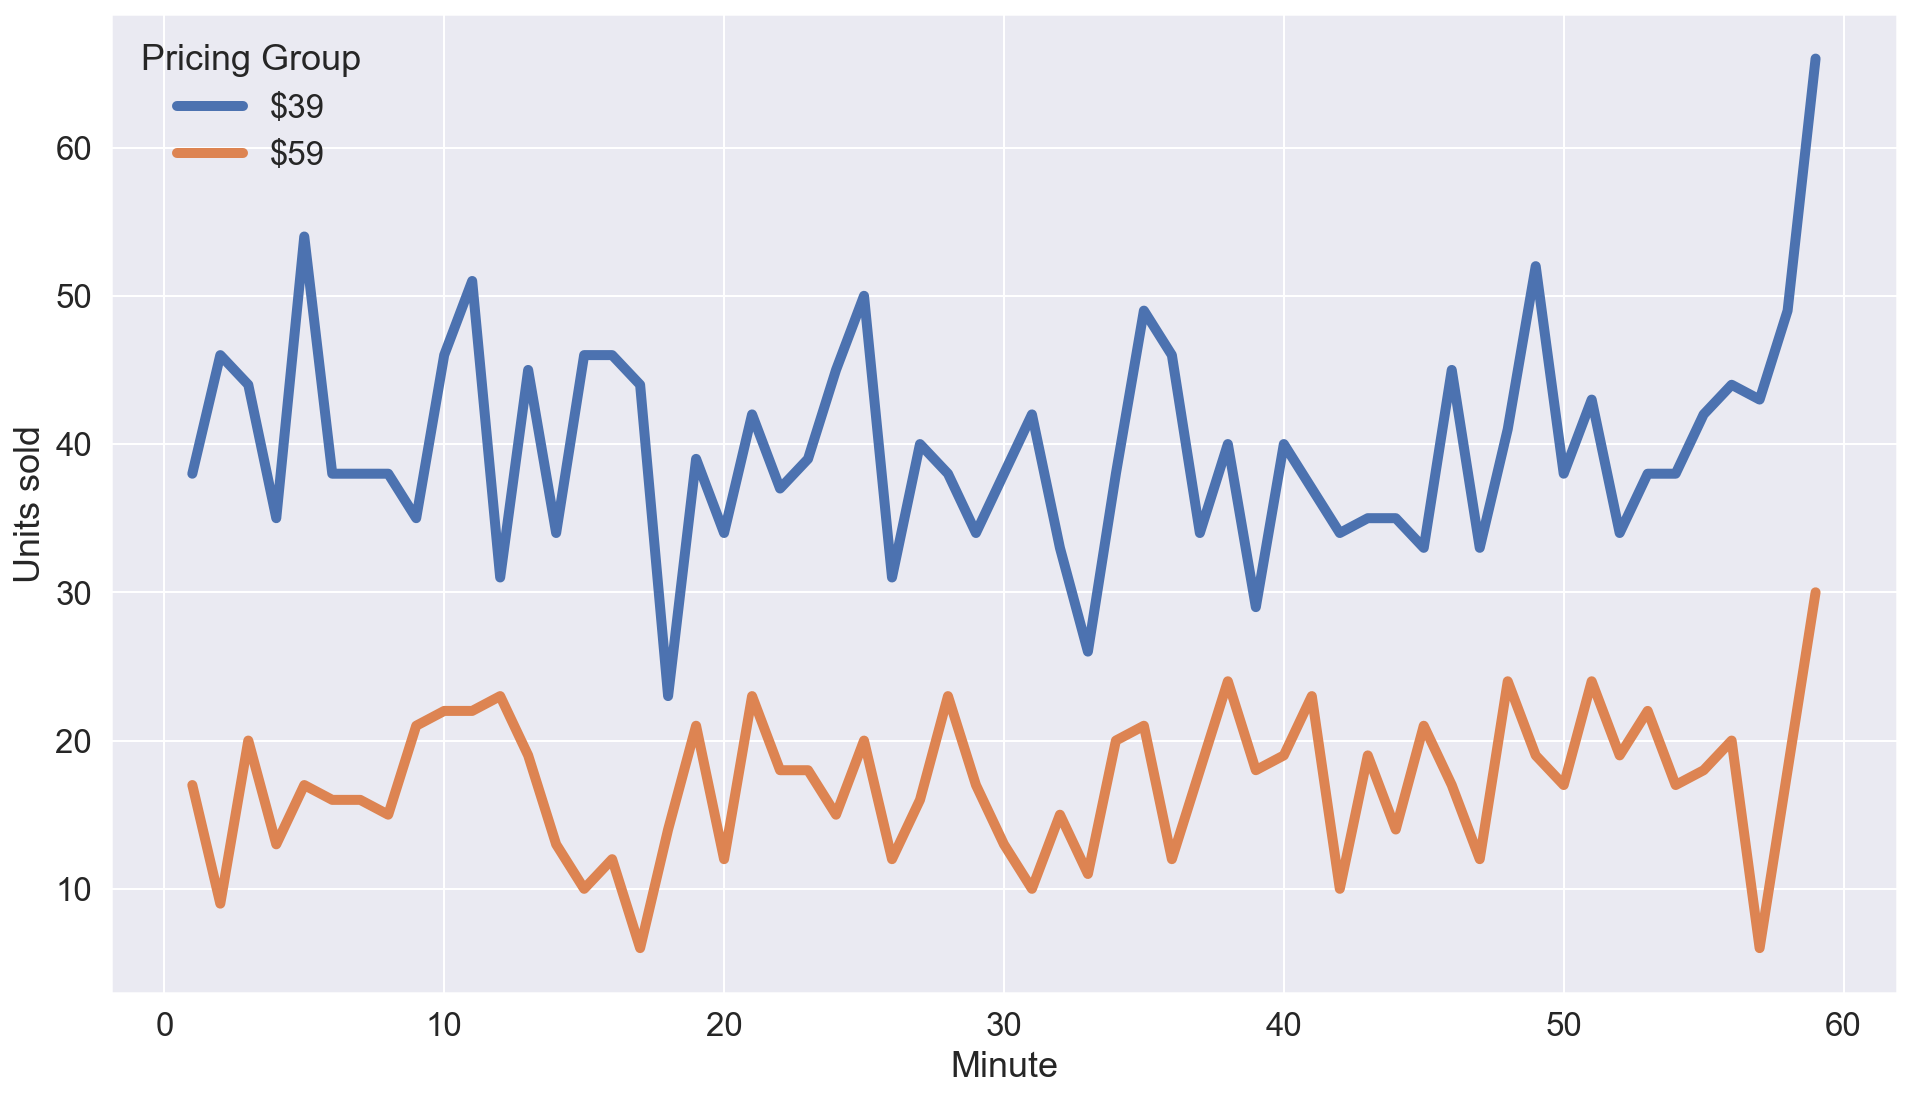

In [165]:
# Plot relationship of units sold over time of day for each group

p = sns.lineplot(data=df_sum_daily_t, x="min", y="counts",
                 hue='test', linewidth=5)
plt.xlabel('Minute')
plt.ylabel('Units sold')
plt.legend(loc='upper left', frameon=False, title='Pricing Group',
           labels=['$39', '$59'])

 ### Daily Revenue grouped by test group


In [166]:
# Extract week variable

df_convert['week'] = df_convert['timestamp'].dt.isocalendar().week

In [167]:
# Calculate weekly totals

df_sum_weekly = df_convert.groupby(['test','week'],
                                dropna=False) \
                            ['price'].sum().reset_index()

In [168]:
# Calculate the daily totals

df_sum_daily = df_convert.groupby(['test','date'],
                                dropna=False) \
                            ['price'].sum().reset_index()
#df_sum_daily[:10]

In [169]:
df_sum_daily.head()

,test,date,price
0,0,2015-03-02,351.0
1,0,2015-03-03,546.0
2,0,2015-03-04,624.0
3,0,2015-03-05,936.0
4,0,2015-03-06,1950.0


In [170]:
# Order df by date

df_sum_daily = df_sum_daily.sort_values(by=['date'], ascending=True)

In [171]:
# Order df by week

df_sum_weekly = df_sum_weekly.sort_values(by=['week'], ascending=True)

In [172]:
# Calculate the daily running total of revenue grouped by pricing test 

df_sum_daily['rev_cumsum'] = df_sum_daily.groupby('test')['price'].transform(pd.Series.cumsum)

In [173]:
# Calculate the weekly running total of revenue grouped by pricing test 

df_sum_weekly['rev_cumsum'] = df_sum_weekly.groupby('test')['price'].transform(pd.Series.cumsum)

In [174]:
# Scale revenue totals by 1000 for interpretation

df_sum_daily['rev_daily_scale'] = df_sum_daily['price']/1000

In [175]:
# Scale revenue totals by 1000 for interpretation

df_sum_weekly['rev_weekly_scale'] = df_sum_weekly['price']/1000

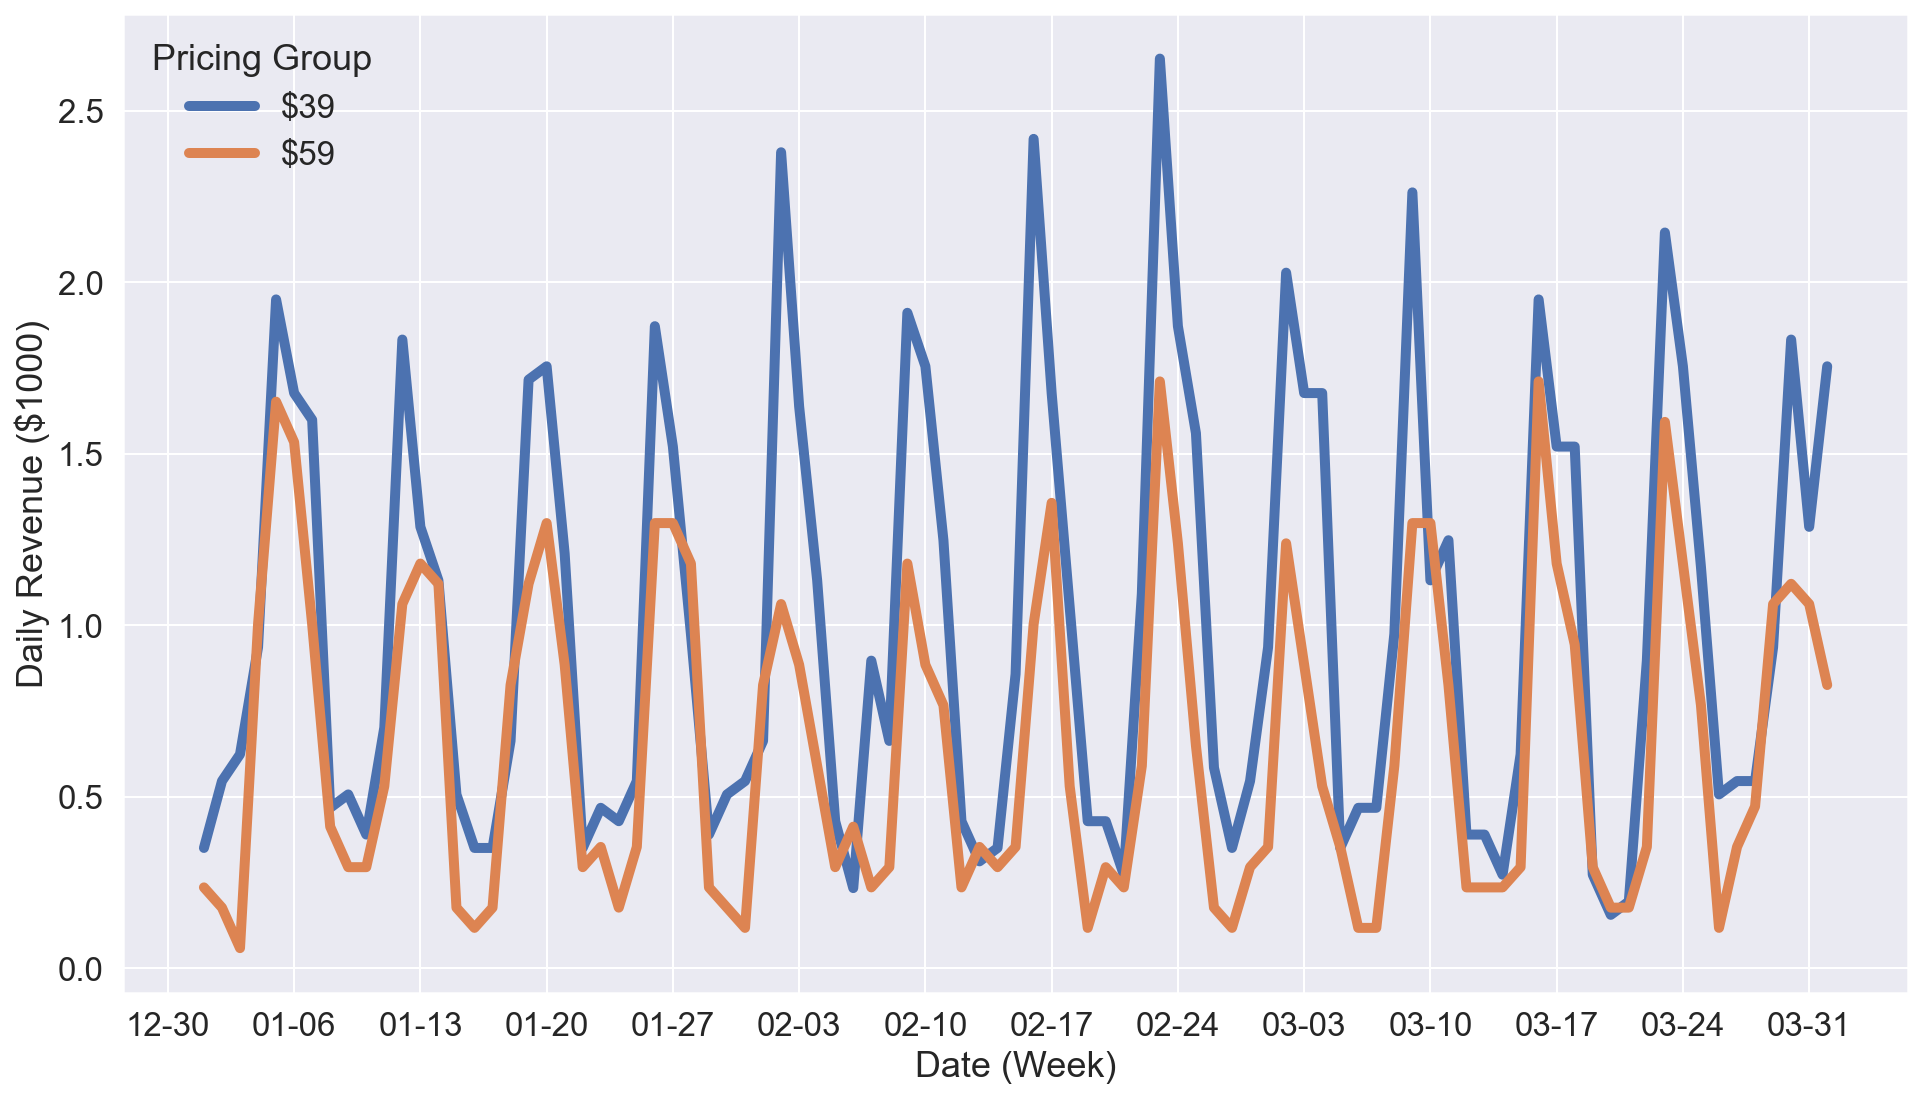

In [176]:
# Plot relationship of total revenue over time for each group

# p = sns.lineplot(data=df_sum_weekly, x="week", y="rev_cumsum_scale",
#                  hue='test', linewidth=5)
p = sns.lineplot(data=df_sum_daily, x="date", y="rev_daily_scale",
                 hue='test', linewidth=5)
plt.xlabel('Date (Week)')
plt.ylabel('Daily Revenue ($1000)')
plt.legend(loc='upper left', frameon=False, title='Pricing Group',
           labels=['$39', '$59'])


    # Define the date format
date_form = DateFormatter("%m-%d")
p.xaxis.set_major_formatter(date_form)

# Ensure a major tick for each week using (interval=1) 
p.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))

- Clearly a day of the week trend, but there don't appear to be strong weekly or even monthly fluctuations. Some differences depending on the pricing group as well. 
- Need to have day of the week variable, probably ordinal to preserve order since it appears to be an increasing trend and then drop

### Daily revenue by day of week

In [177]:
# Extract day of week variable

df_convert['weekday'] = df_convert['timestamp'].dt.weekday
df_convert['day_name'] = df_convert['timestamp'].dt.day_name()

In [178]:
# Calculate daily totals

df_cts_weekday = df_convert.groupby(['test','weekday'],
                                dropna=False) \
                            ['price'].count().reset_index()
df_cts_weekday.rename(columns={"price":"counts"}, inplace=True)

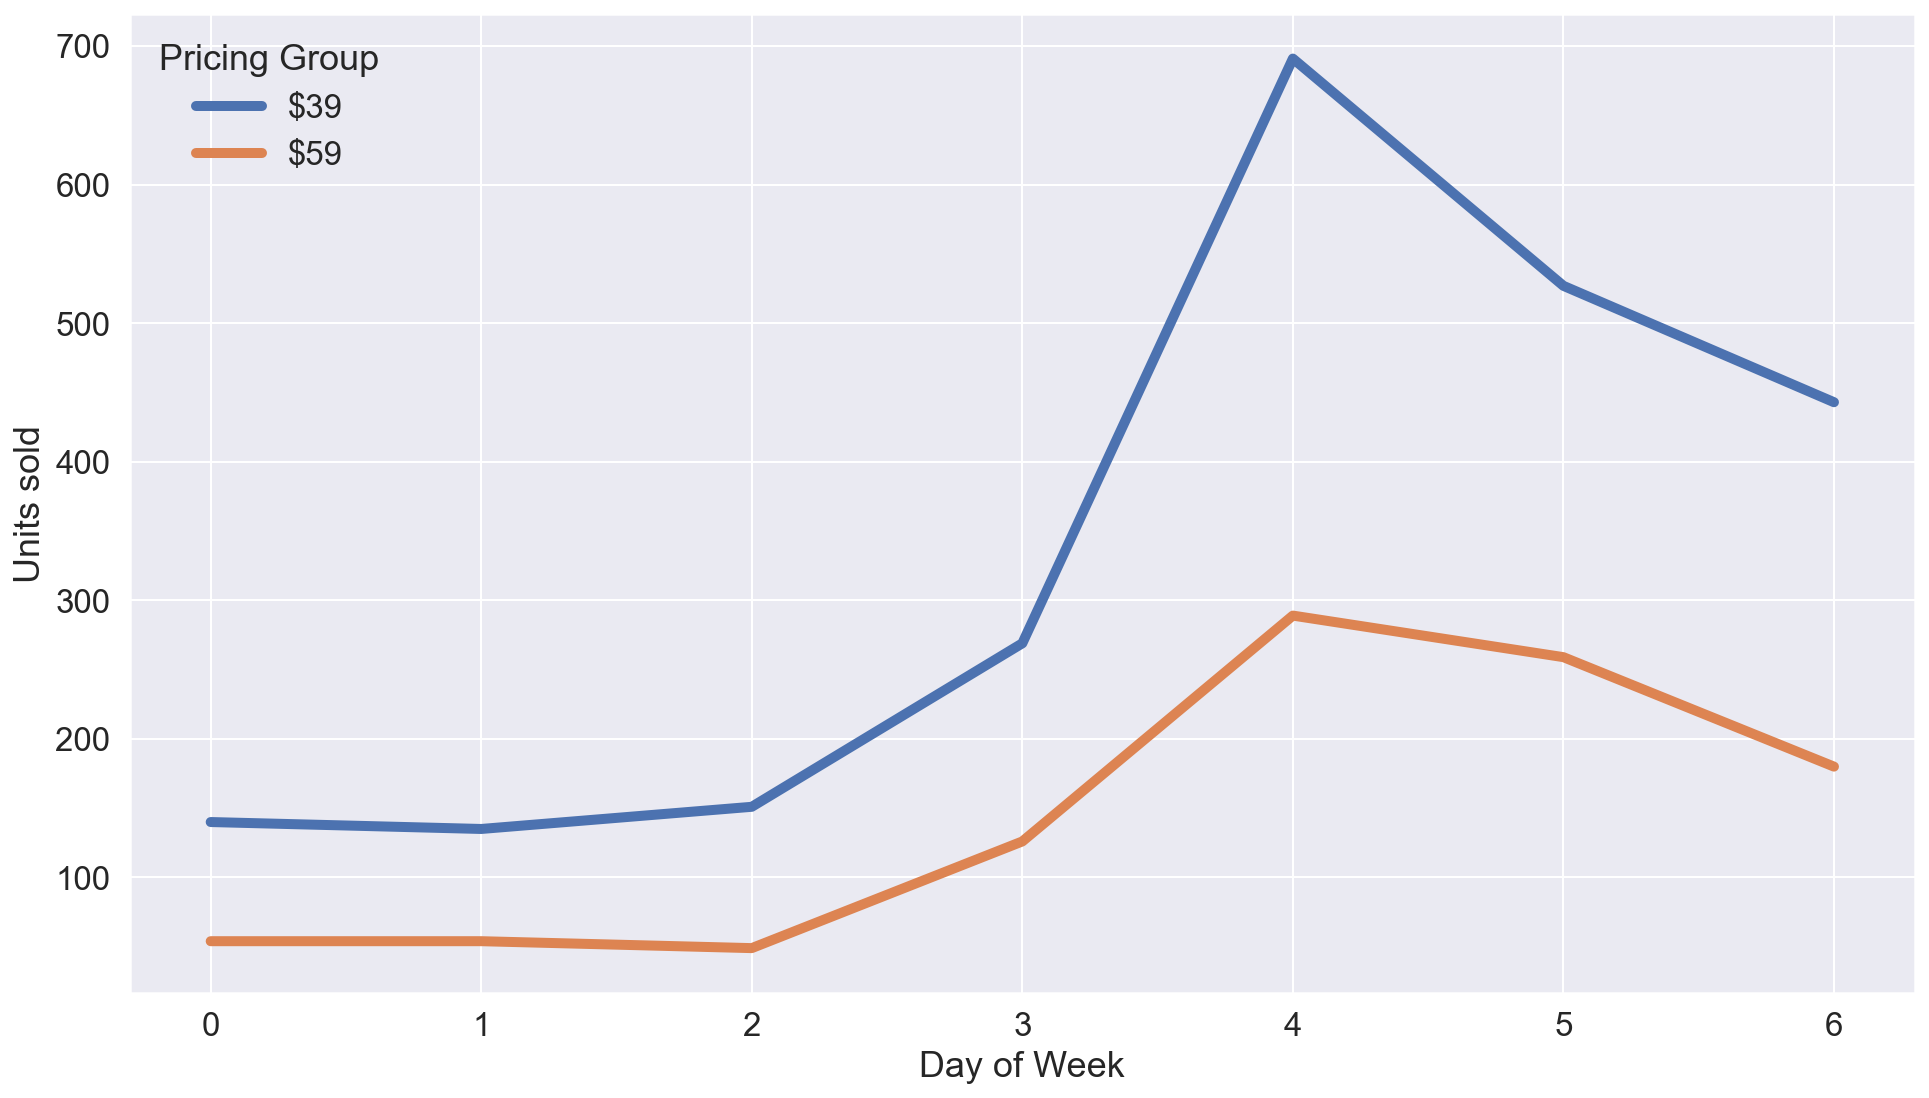

In [179]:
# Plot relationship of units sold over time of day for each group

p = sns.lineplot(data=df_cts_weekday, x="weekday", y="counts",
                 hue='test', linewidth=5)
plt.xlabel('Day of Week')
plt.ylabel('Units sold')
plt.legend(loc='upper left', frameon=False, title='Pricing Group',
           labels=['$39', '$59'])

- Peak in sales on Friday
- Weekend sales appear to be higher than during the week

### Conversion counts by grouping factors

In [180]:
df_clean.head()

,user_id,timestamp,source,device,os,test,price,converted,source_type,date,time,city,country,lat,long
0,604839,2015-05-08 03:38:34,facebook,mobile,apple,0,39.0,0,ads,2015-05-08,03:38:34,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,google,mobile,android,0,39.0,0,seo,2015-05-10,21:08:46,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,bing,mobile,android,0,39.0,0,ads,2015-04-04,15:01:23,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,apple,1,59.0,0,direct_traffic,2015-05-07,07:26:01,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,facebook,web,apple,0,39.0,0,ads,2015-05-24,11:04:40,Fishers,USA,39.95,-86.02


In [181]:
# Get total value counts of conversions and non-conversions by factors

df_convert_cts = (
    df_clean.groupby(['test','source_type','source','device','converted'],
                              dropna=True) \
                                ['user_id'].count()
)
df_convert_cts

test  source_type      source           device  converted
0     ads              bing             mobile  0             6814
                                                1               99
                                        web     0             4880
                                                1               64
                       facebook         mobile  0            15733
                                                1              399
                                        web     0            11204
                                                1              274
                       google           mobile  0            17381
                                                1              405
                                        web     0            12681
                                                1              298
                       other            mobile  0             8698
                                                1              134
    

- Lots of variation in conversion counts
- This would require some pretty complex interactions to tease apart
- Suggests a modelling approach that can test for these (ideally without specification)
- Will also need to regularize given how many interaction possibilities there are

In [182]:
# Check counts by city

df_city_cts = (
    df_clean.groupby(['city'],
                              dropna=True) \
                                ['user_id'].count() \
    .reset_index()
)

In [183]:
# Look at dist. numerically 

df_city_cts.describe()

,user_id
count,922.000000
mean,279.065076
std,911.119304
min,1.000000
25%,74.000000
50%,152.000000
75%,259.000000
max,24072.000000


In [184]:
df_city_cts.sort_values(by='user_id', ascending=True)[:10]

,city,user_id
237,East Lake,1
142,Cerritos,1
580,Ocala,1
188,Costa Mesa,1
548,New Milford,1
4,Albuquerque,2
844,Tustin,2
455,Little Rock,2
216,Delray Beach,3
44,Baltimore,3


Text(0, 0.5, 'Counts of customer interactions')

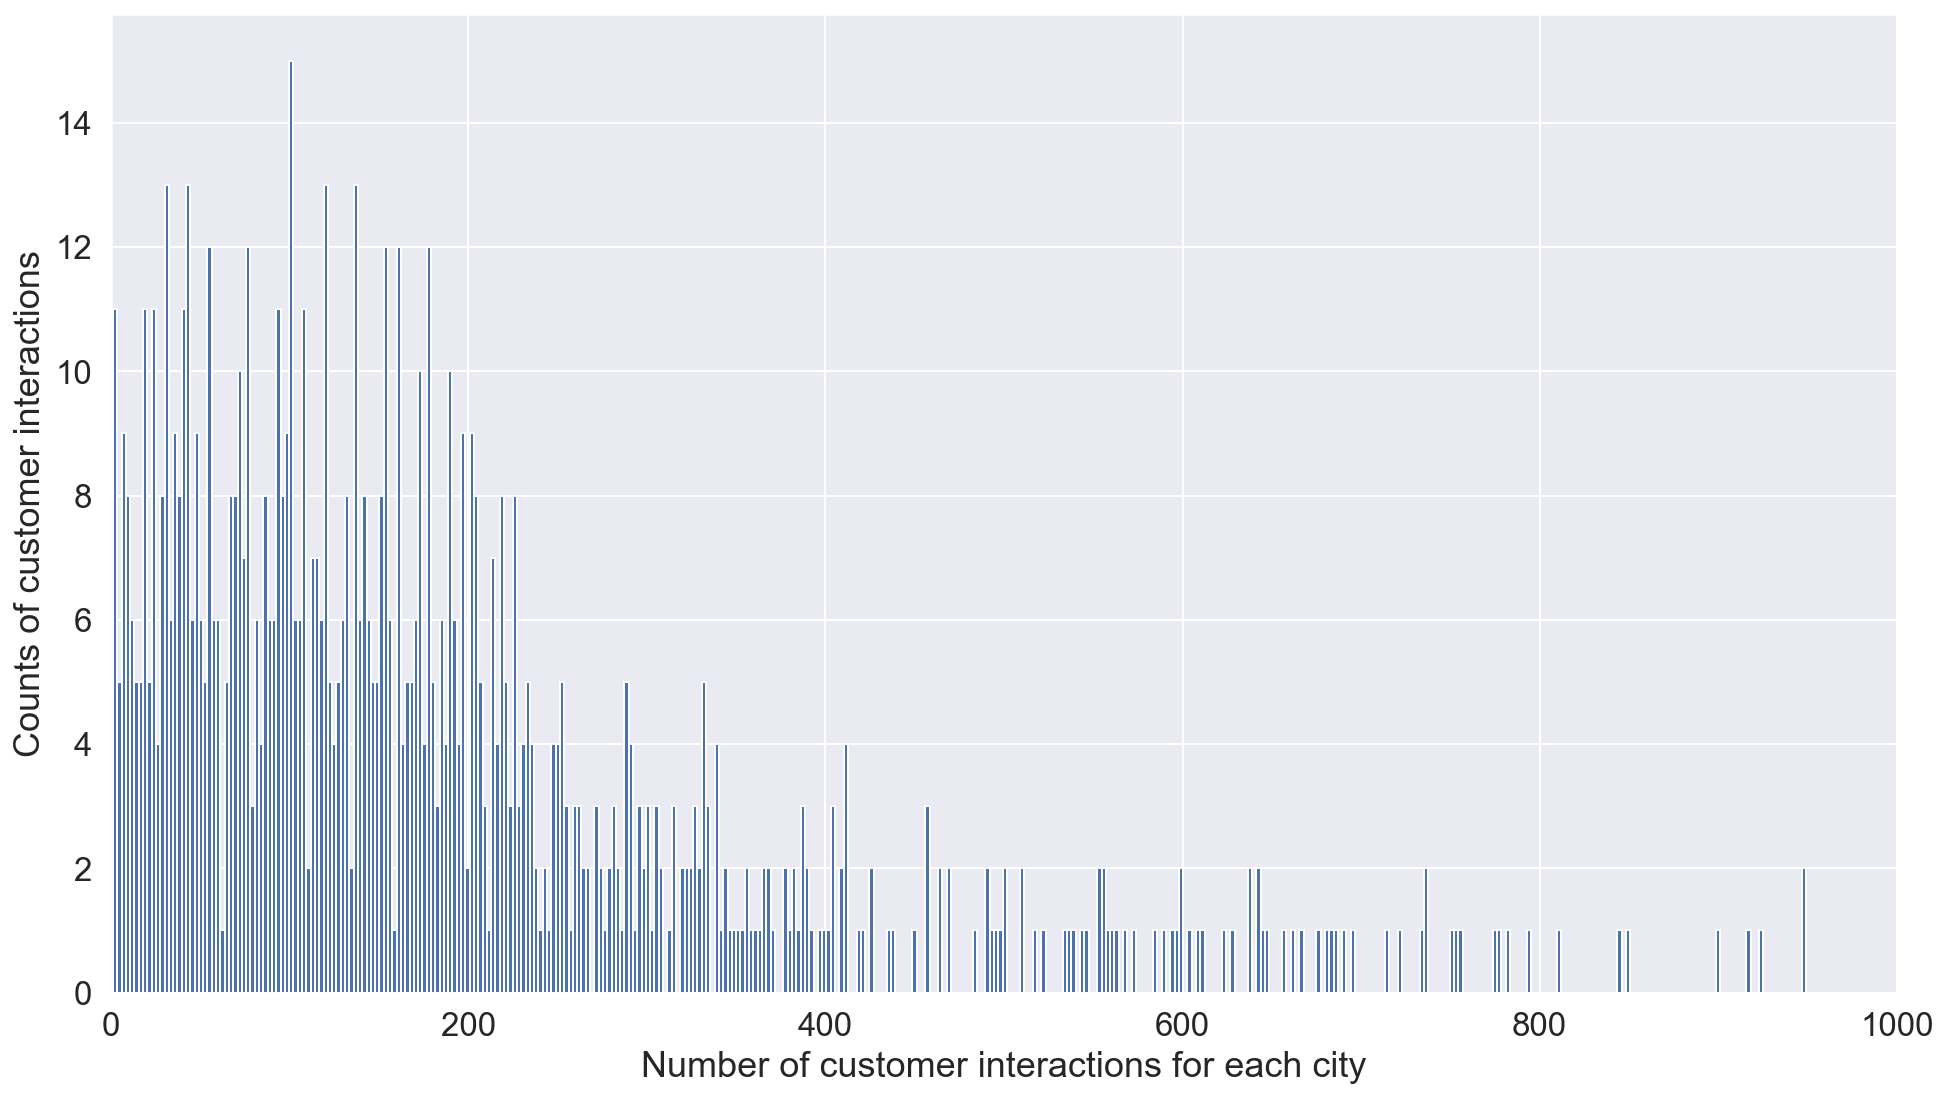

In [185]:
# Plot skewed conversion and non-conversion count distribution

df_city_cts['user_id'].hist(bins=10000)
plt.xlim(0, 1000)
plt.xlabel('Number of customer interactions for each city')
plt.ylabel('Counts of customer interactions')

- Most cities have low numbers of customer interactions
- Distribution is highly right skewed

Text(0, 0.5, 'Counts of customer interactions')

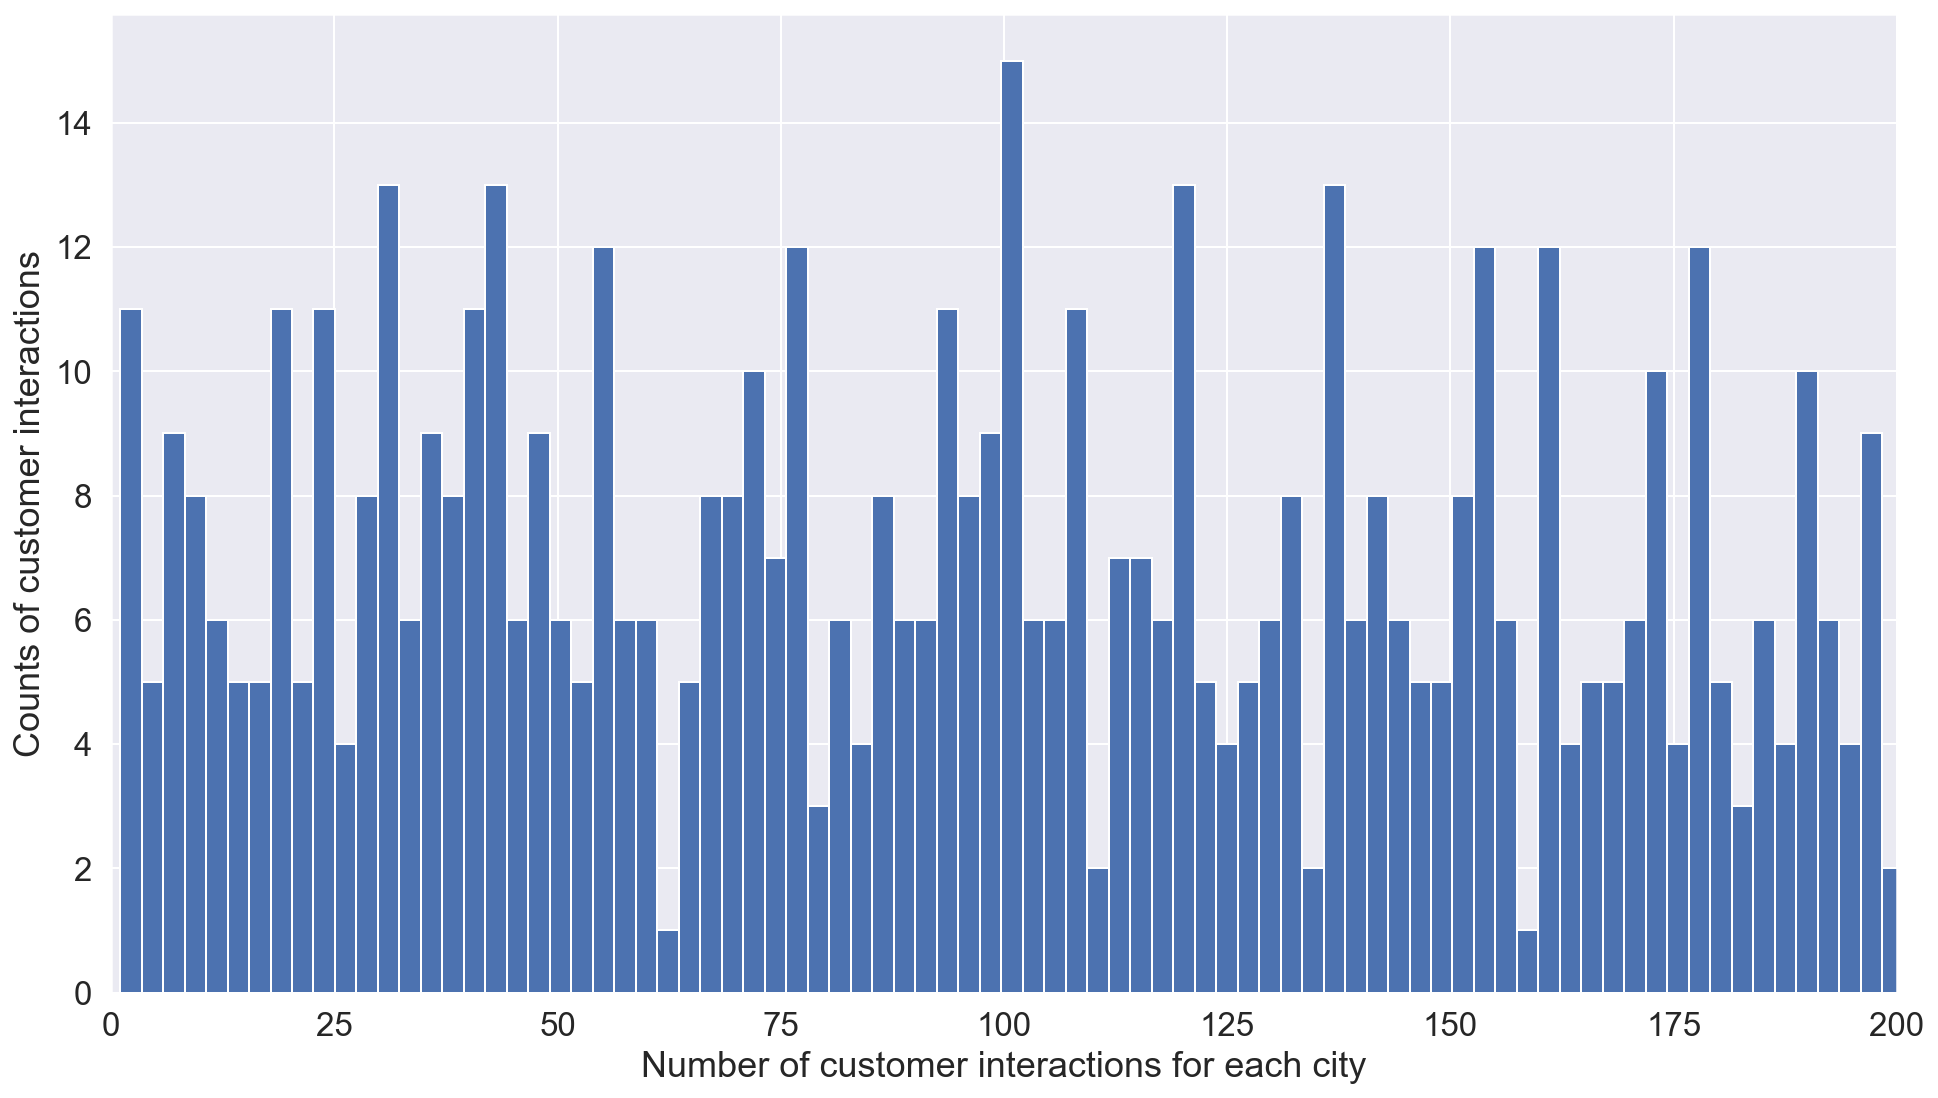

In [186]:
# Plot skewed conversion and non-conversion count distribution

df_city_cts['user_id'].hist(bins=10000)
plt.xlim(0, 200)
plt.xlabel('Number of customer interactions for each city')
plt.ylabel('Counts of customer interactions')

In [187]:
# Check how conversion counts vary by cities

df_convert_city_cts = (
    df_clean.groupby(['test','city','converted'],
                              dropna=True) \
                                ['user_id'].count()
)

In [188]:
df_convert_city_cts[:10]

test  city         converted
0     Abilene      0            255
                   1              6
      Akron        0            204
                   1              5
      Alameda      0             99
                   1              2
      Albany       0            335
                   1              4
      Albuquerque  0              2
      Alexandria   0             83
Name: user_id, dtype: int64

### Plot conversion counts on map

In [189]:
df_clean.head()

,user_id,timestamp,source,device,os,test,price,converted,source_type,date,time,city,country,lat,long
0,604839,2015-05-08 03:38:34,facebook,mobile,apple,0,39.0,0,ads,2015-05-08,03:38:34,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,google,mobile,android,0,39.0,0,seo,2015-05-10,21:08:46,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,bing,mobile,android,0,39.0,0,ads,2015-04-04,15:01:23,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,apple,1,59.0,0,direct_traffic,2015-05-07,07:26:01,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,facebook,web,apple,0,39.0,0,ads,2015-05-24,11:04:40,Fishers,USA,39.95,-86.02


In [190]:
# Check how conversion counts vary by lat and long

df_convert_map_cts = (
    df_clean.groupby(['test','long','lat','converted'],
                              dropna=True) \
                                ['user_id'].count().reset_index()
)

In [191]:
# Check how conversion counts vary by cities

df_convert_map_cts = (
    df_clean.groupby(['test','city','converted'],
                              dropna=True) \
                                ['user_id'].count().reset_index()
)

In [192]:
# Select lat and long and city cols

df_convert_map_coord= (
    df_clean.groupby(['city'],
                              dropna=True)[['lat','long']].first().reset_index()
)

In [193]:
# Add lat and long data to conversion count data by city

df_convert_map_cts = df_convert_map_cts.merge(df_convert_map_coord,
                                              on='city', how='left')

In [194]:
# Filter out non-conversions and set price group to $39

df_convert_yes_0_map_cts = df_convert_map_cts.query("converted == 1 & test == 0")

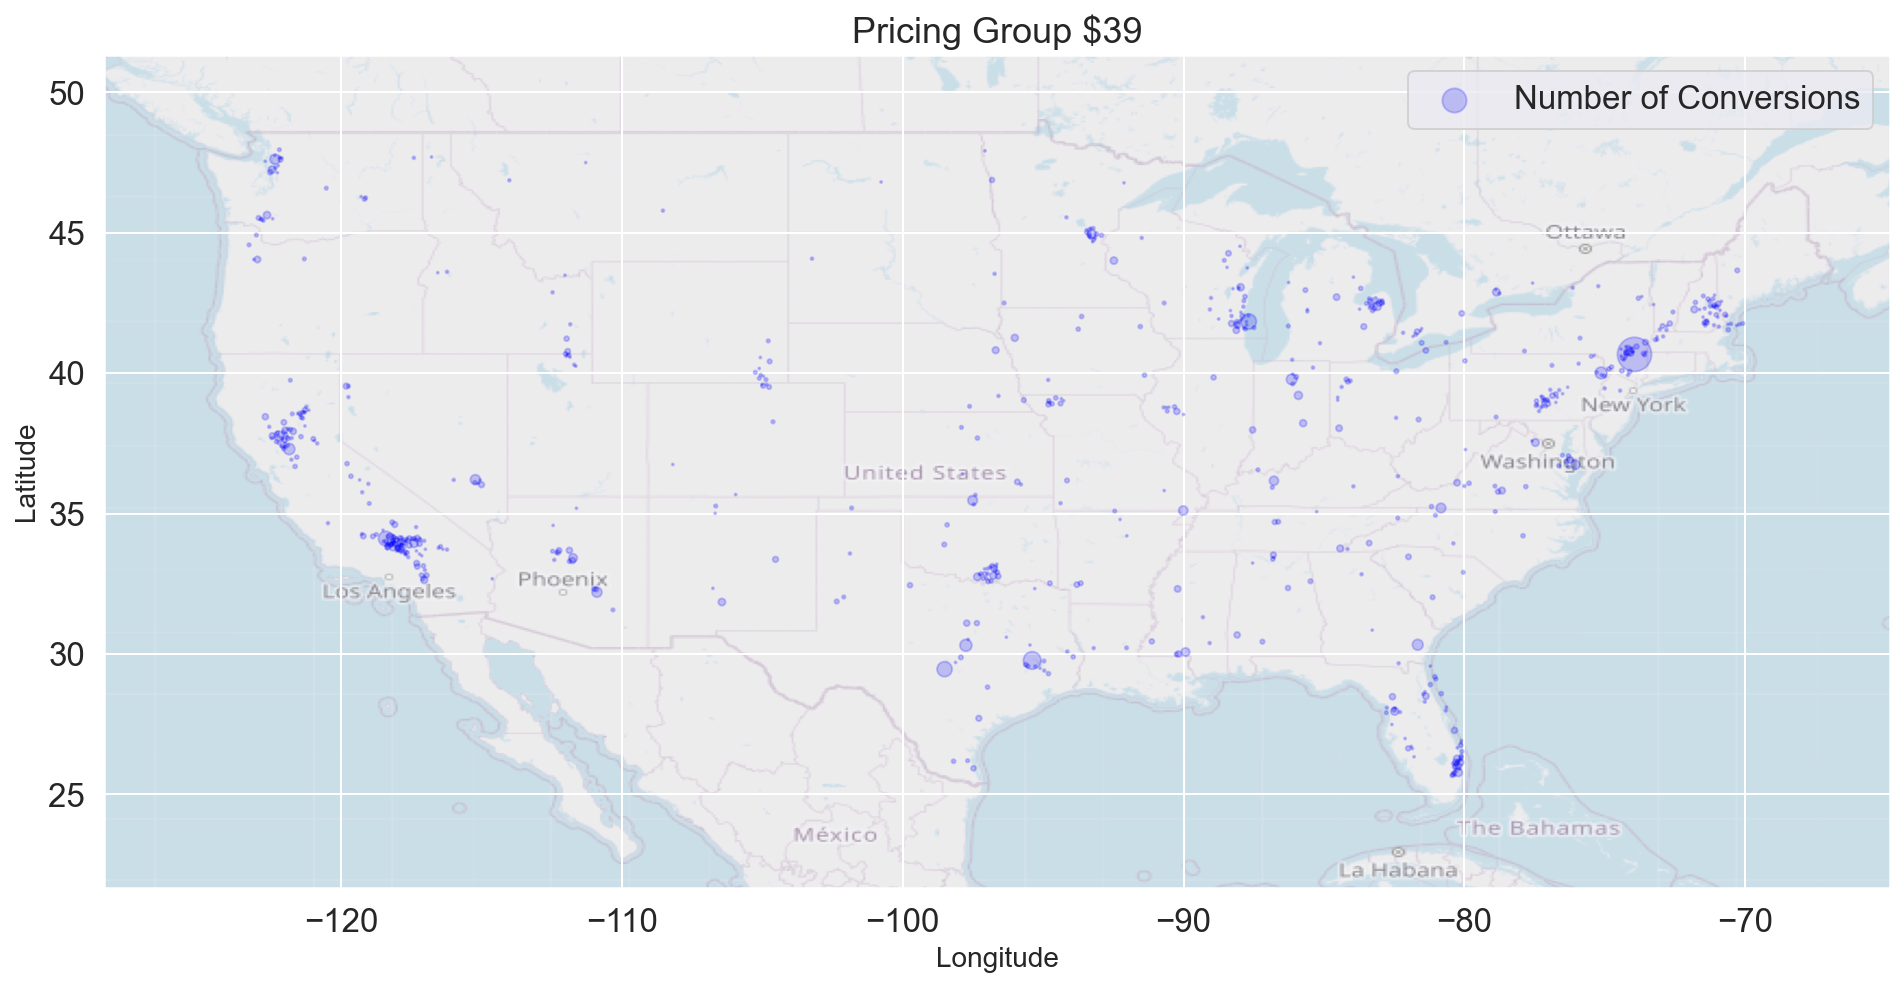

In [195]:
usa_img=mpimg.imread(rpath+'images/usa_map.png')
ax = df_convert_yes_0_map_cts.plot(kind="scatter", x="long", y="lat",
                             #figsize=(10,7),
                       s=df_convert_yes_0_map_cts['user_id'],
                             label="Number of Conversions",
                                 alpha=0.2,
                                 color='blue'
                      )

plt.imshow(usa_img, extent=[-128.44, -64.85, 21.65, 51.34], alpha=0.5) 
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.title('Pricing Group $39')
plt.show()

In [196]:
# Filter out non-conversions and set price group to $39

df_convert_yes_1_map_cts = df_convert_map_cts.query("converted == 1 & test ==1")

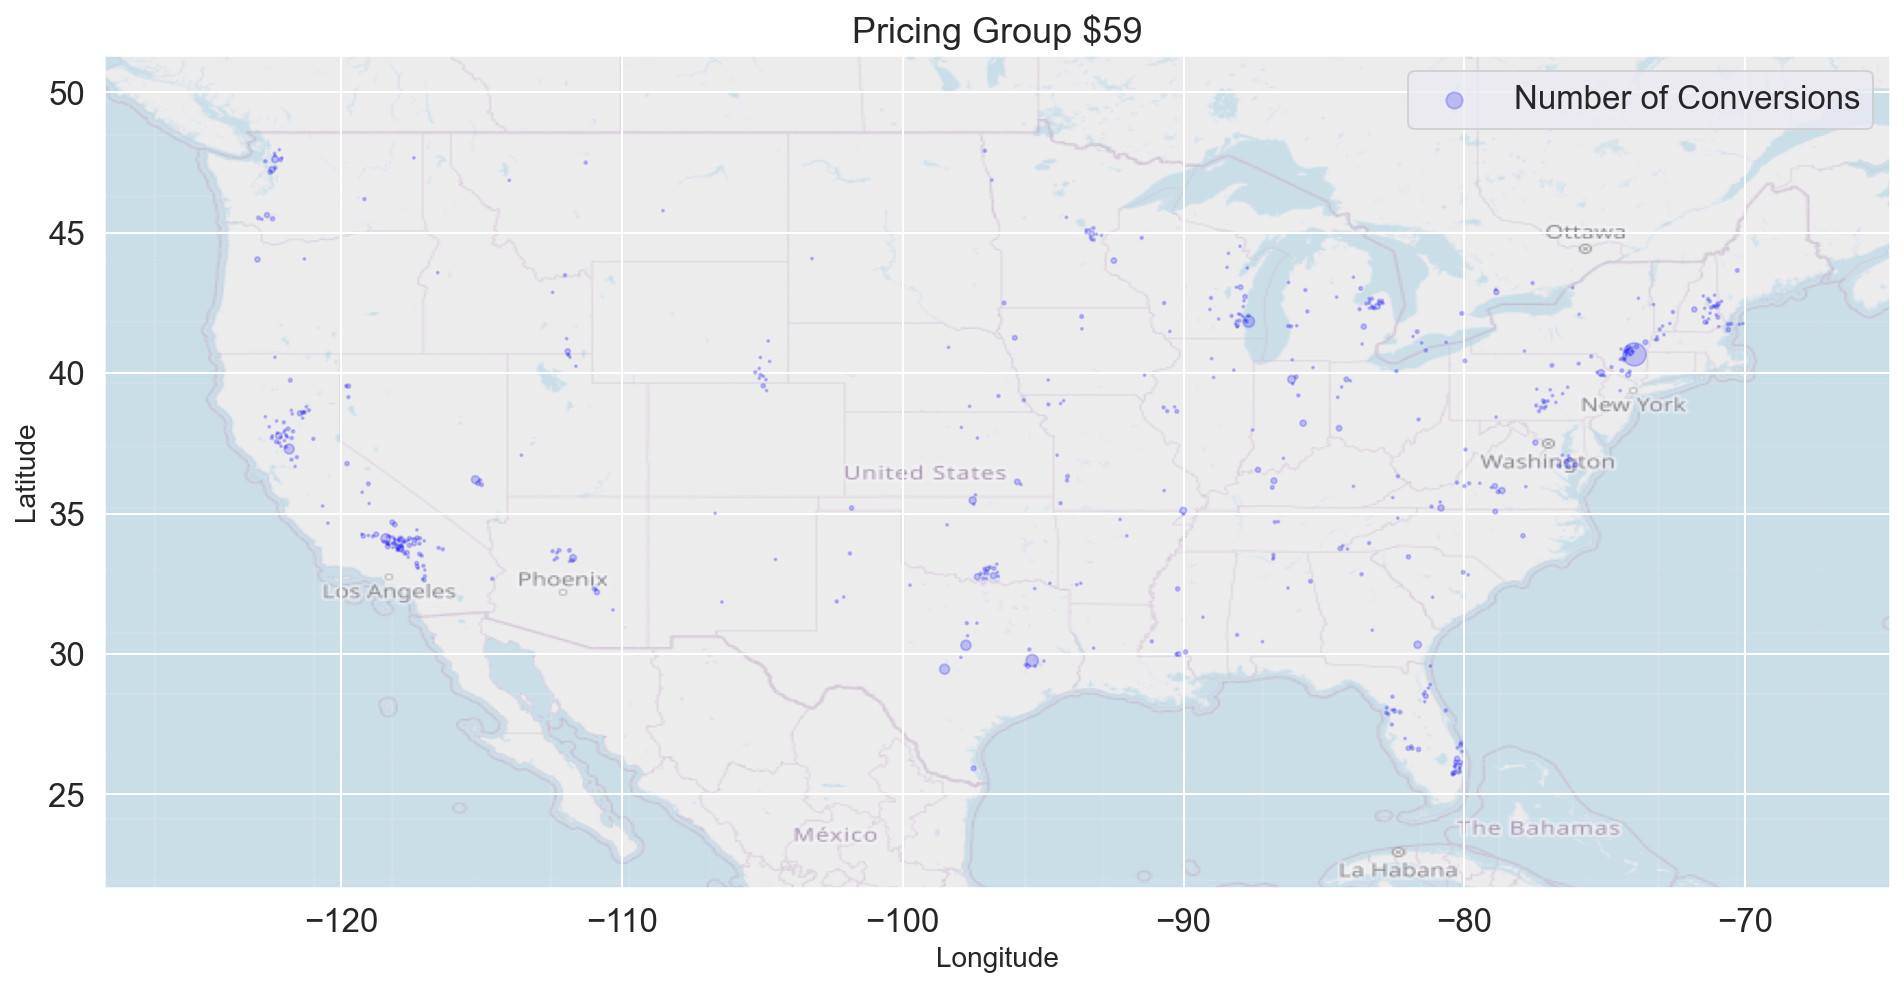

In [197]:
usa_img=mpimg.imread(rpath+'images/usa_map.png')
ax = df_convert_yes_1_map_cts.plot(kind="scatter", x="long", y="lat",
                             #figsize=(10,7),
                       s=df_convert_yes_1_map_cts['user_id'],
                             label="Number of Conversions",
                                 alpha=0.2,
                                 color='blue'
                      )

plt.imshow(usa_img, extent=[-128.44, -64.85, 21.65, 51.34], alpha=0.5) 
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.title('Pricing Group $59')
plt.show()

- Clearly some geographical variation between test groups but also across the US as well

### Check how lat and long coord match up with cities

In [198]:
# Create column for unique combinations of lat and long
df_eda['lat_long'] = df_eda['lat'].astype(str) + df_eda['long'].astype(str)

In [199]:
# Calculate number of unique lat and long combos

df_eda['lat_long'].nunique()

990

In [200]:
# Calculate number of unique cities combos

df_eda['city'].nunique()

920

- Few extra lat and long combos but not many, so cities contain most information here
- Perhaps drop lat and long since city is more interpretatable